# Evaluation Code for KSQL and ML
Before evaluating, please run KSQL infrastructure with `test.pcap` generated from `../datasets/preparation2.py`, then run `../rule-detection/evaluation/consumer/script.py` to consume the results from Kafka, and lastly run `../rule-detection/evaluation/ksql_evaluation_dos.py` and `../rule-detection/evaluation/ksql_evaluation_ps.py` to find list of packets in the pcap (in the form of index) that is malicious/detected.

**Metrics**
- Accuracy, Precision, Recall, F1-Score
- Inference Time for ML

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
import time

In [2]:
DOS_MODEL_LOCATION = "../ai-detection/notebooks/models/postfs"
PS_MODEL_LOCATION = "../ai-detection/notebooks/modelsps/postfs"

## Post-Processing for KSQL Predictions

In [3]:
# Get PCAP Indexes of all flows
# For example, if 125th, 126th, and 127th is part of k-th flow (in whole dataset train & test), then flow_packets[k] = [125, 126, 127]
flow_packets = []
with open("../datasets/output-old/pcap_indexes_run_index.txt") as file:
    for line in file:
        indexes = line.strip().split(",")
        if len(indexes[-1]) == 0:
            indexes = indexes[:-1]
        indexes = [int(x) for x in indexes]
        flow_packets.append(indexes)

In [4]:
# Creating mapping to convert whole dataset PCAP indexes to test dataset PCAP indexes
full_to_test_mapping = {}
with open("../datasets/output-old/test_pcap_index_mapping.txt") as file:
    for line in file:
        before, after = line.strip().split(",")
        before = int(before)
        after = int(after)
        assert before not in full_to_test_mapping
        full_to_test_mapping[before] = after

In [5]:
# Convert using mapping
test_flow_packets = []
for cur_packets in flow_packets:
    new_packets = []
    is_in_test = True

    debug_partial = False
    for idx in cur_packets:
        if idx not in full_to_test_mapping:
            is_in_test = False
            assert not debug_partial # if assertion error, there may be problem in your dataset preparation
            break
        debug_partial = True
        new_packets.append(full_to_test_mapping[idx])
    if is_in_test:
        test_flow_packets.append(new_packets)
    else:
        test_flow_packets.append(None)

In [6]:
test_flow_packets_set = [set(i) if i is not None else None for i in test_flow_packets]

In [7]:
np_test_flow_packets_set = pd.Series(np.array(test_flow_packets_set))
flow_packets_set_test_only = np_test_flow_packets_set[~np_test_flow_packets_set.isna()]

In [8]:
with open("../rule-detection/evaluation/detected_ksql_2_slowloris.txt") as file:
    detected_dos_idxs = [int(x.strip()) for x in file.readlines()]
detected_dos_idx_set = set(detected_dos_idxs)

with open("../rule-detection/evaluation/detected_ksql_2_portscan.txt") as file:
    detected_portscan_idxs = [int(x.strip()) for x in file.readlines()]
detected_portscan_idx_set = set(detected_portscan_idxs)

In [9]:
is_detected_dos = np.array([len(detected_dos_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_dos = pd.Series(is_detected_dos)

is_detected_portscan = np.array([len(detected_portscan_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_portscan = pd.Series(is_detected_portscan)

In [10]:
is_detected_dos.index = flow_packets_set_test_only.index
is_detected_portscan.index = flow_packets_set_test_only.index

In [11]:
# Load Test Dataset
flink_test = pd.read_csv('../datasets/output/test_final.csv', index_col=0)

In [12]:
assert set(flink_test['Old Index'].values).issubset(set(is_detected_dos.index))
assert set(flink_test['Old Index'].values).issubset(set(is_detected_portscan.index))

In [13]:
is_detected_dos_df = pd.DataFrame(is_detected_dos, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_dos_df['Binary Prediction'] = np.where(is_detected_dos_df['Binary Prediction'], 'Slowloris', 'Not Slowloris')

is_detected_ps_df = pd.DataFrame(is_detected_portscan, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_ps_df['Binary Prediction'] = np.where(is_detected_ps_df['Binary Prediction'], 'Portscan', 'Not Portscan')

In [14]:
flink_test_binary_dos = flink_test.merge(is_detected_dos_df, on=['Old Index'], how='left', indicator=True)
flink_test_binary_ps = flink_test.merge(is_detected_ps_df, on=['Old Index'], how='left', indicator=True)

In [15]:
flink_test_binary_dos["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [16]:
flink_test_binary_ps["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [17]:
flink_test_binary_dos['Binary Label'] = np.where(flink_test_binary_dos['Label'] == 'Slowloris', 'Slowloris', 'Not Slowloris')
flink_test_binary_ps['Binary Label'] = np.where(flink_test_binary_ps['Label'] == 'Portscan', 'Portscan', 'Not Portscan')

In [18]:
y_true_dos = flink_test_binary_dos['Binary Label']
y_pred_ksql_dos = flink_test_binary_dos['Binary Prediction']

y_true_ps = flink_test_binary_ps['Binary Label']
y_pred_ksql_ps = flink_test_binary_ps['Binary Prediction']

# Model Preparation

In [49]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{DOS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{DOS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

In [50]:
fs = ['Fwd IAT Min', 'Bwd IAT Mean', 'Fwd Seg Size Min', 'Flow Packets/s', 'Fwd Packets/s', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Bwd IAT Min', 'Flow IAT Mean', 'FIN Flag Count', 'Bwd Init Win Bytes', 'Fwd Bulk Rate Avg', 'Active Min', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Header Length', 'Bwd Packet Length Mean', 'Subflow Bwd Bytes', 'Flow Duration', 'Flow IAT Min', 'Total Bwd packets', 'Fwd Segment Size Avg', 'FWD Init Win Bytes', 'Packet Length Mean', 'Down/Up Ratio', 'ACK Flag Count', 'Fwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Max', 'Subflow Fwd Packets', 'Fwd Bytes/Bulk Avg', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd Header Length']

In [51]:
top_3_models = ['rf', 'xg', 'lgbm']

In [52]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

array([0, 1])

In [53]:
X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

## Accuracy, Precision, Recall, F1-Score

### DoS

#### KSQL

Accuracy of KSQL: 0.7858369768894441
Precision of KSQL: 0.4953329286897751
Recall of KSQL: 0.3958494474232751
F1-score of KSQL: 0.4400384733091418
               precision    recall  f1-score   support

Not Slowloris    0.99067   0.79170   0.88008    152558
    Slowloris    0.00000   0.00000   0.00000      1138

     accuracy                        0.78584    153696
    macro avg    0.49533   0.39585   0.44004    153696
 weighted avg    0.98333   0.78584   0.87356    153696



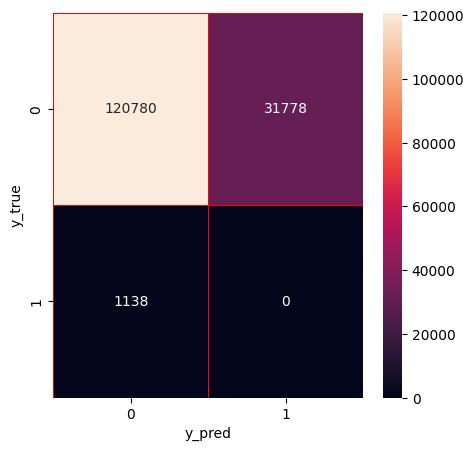

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_pred_ksql_dos, average='macro')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_dos, y_pred_ksql_dos)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_dos, y_pred_ksql_dos, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_pred_ksql_dos)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [45]:
flink_test_binary_dos[(flink_test_binary_dos['Label'] == 'Portscan') & (flink_test_binary_dos['Binary Prediction'] == 'Slowloris')]

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
63614,172.16.0.1,54176,192.168.10.50,3372,6,2017-07-07 17:55:45.857960,73.0,1,1,0.0,...,0,0,0,0,73,Portscan,782541,Slowloris,both,Not Slowloris
63615,172.16.0.1,46948,192.168.10.50,7004,6,2017-07-07 17:55:45.857984,65.0,1,1,0.0,...,0,0,0,0,65,Portscan,716537,Slowloris,both,Not Slowloris
63616,172.16.0.1,42260,192.168.10.50,2144,6,2017-07-07 17:55:45.858008,52.0,1,1,0.0,...,0,0,0,0,52,Portscan,793478,Slowloris,both,Not Slowloris
63617,172.16.0.1,52120,192.168.10.50,1862,6,2017-07-07 17:55:45.858047,43.0,1,1,0.0,...,0,0,0,0,43,Portscan,959673,Slowloris,both,Not Slowloris
63618,172.16.0.1,59188,192.168.10.50,1078,6,2017-07-07 17:55:45.858090,48.0,1,1,0.0,...,0,0,0,0,48,Portscan,562621,Slowloris,both,Not Slowloris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115507,172.16.0.1,47339,192.168.10.50,10001,6,2017-07-07 18:23:52.026658,45.0,1,1,0.0,...,0,0,0,0,45,Portscan,964756,Slowloris,both,Not Slowloris
115508,172.16.0.1,47339,192.168.10.50,5987,6,2017-07-07 18:23:52.026752,37.0,1,1,0.0,...,0,0,0,0,37,Portscan,751138,Slowloris,both,Not Slowloris
115509,172.16.0.1,47339,192.168.10.50,2135,6,2017-07-07 18:23:52.026762,35.0,1,1,0.0,...,0,0,0,0,35,Portscan,704995,Slowloris,both,Not Slowloris
115513,172.16.0.1,44870,192.168.10.50,2000,6,2017-07-07 18:23:53.255404,57.0,1,1,0.0,...,0,0,0,0,57,Portscan,1038574,Slowloris,both,Not Slowloris


#### Machine Learning

Prediction time per sample:  8.39373133665518e-05
Accuracy of DT: 0.9981587028940245
Precision of DT: 0.9973418191762222
Recall of DT: 0.876967320573758
F1-score of DT: 0.9287512698990616
               precision    recall  f1-score   support

Not Slowloris    0.99817   0.99998   0.99907    152558
    Slowloris    0.99652   0.75395   0.85843      1138

     accuracy                        0.99816    153696
    macro avg    0.99734   0.87697   0.92875    153696
 weighted avg    0.99816   0.99816   0.99803    153696



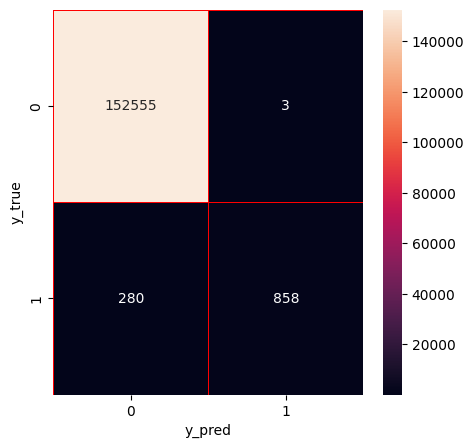

In [55]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0012571051446889654
Accuracy of RF: 0.997924474286904
Precision of RF: 0.9983509211887862
Recall of RF: 0.8602779176370641
F1-score of RF: 0.918058699173386
               precision    recall  f1-score   support

Not Slowloris    0.99792   0.99999   0.99896    152558
    Slowloris    0.99878   0.72056   0.83716      1138

     accuracy                        0.99792    153696
    macro avg    0.99835   0.86028   0.91806    153696
 weighted avg    0.99793   0.99792   0.99776    153696



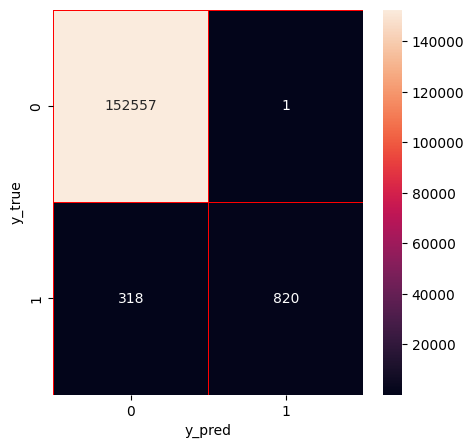

In [56]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0007611660815367421
Accuracy of ET: 0.9976577139287945
Precision of ET: 0.9962913872901338
Recall of ET: 0.8435721274902598
F1-score of ET: 0.9058556466861101
               precision    recall  f1-score   support

Not Slowloris    0.99767   0.99997   0.99882    152558
    Slowloris    0.99491   0.68717   0.81289      1138

     accuracy                        0.99766    153696
    macro avg    0.99629   0.84357   0.90586    153696
 weighted avg    0.99765   0.99766   0.99744    153696



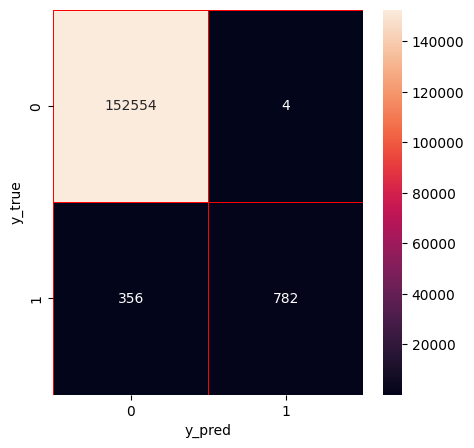

In [57]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00019965477345165004
Accuracy of XG: 0.9978268790339371
Precision of XG: 0.997065642228705
Recall of XG: 0.8545595877090832
F1-score of XG: 0.9137243021617274
               precision    recall  f1-score   support

Not Slowloris    0.99783   0.99998   0.99891    152558
    Slowloris    0.99630   0.70914   0.82854      1138

     accuracy                        0.99783    153696
    macro avg    0.99707   0.85456   0.91372    153696
 weighted avg    0.99782   0.99783   0.99765    153696



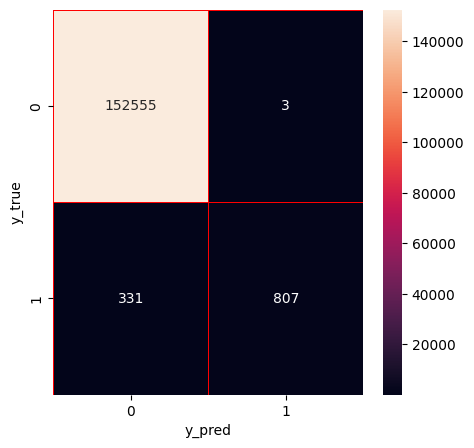

In [58]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0005332664254057688
Accuracy of LGBM: 0.9981391838434311
Precision of LGBM: 0.9984821845534751
Recall of LGBM: 0.8747770389024419
F1-score of LGBM: 0.927744613029722
               precision    recall  f1-score   support

Not Slowloris    0.99814   0.99999   0.99906    152558
    Slowloris    0.99883   0.74956   0.85643      1138

     accuracy                        0.99814    153696
    macro avg    0.99848   0.87478   0.92774    153696
 weighted avg    0.99814   0.99814   0.99801    153696



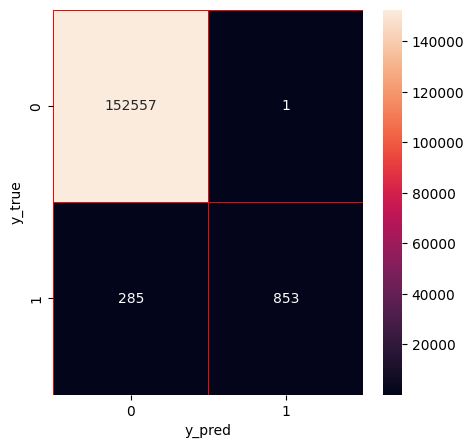

In [59]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00015845087550963655
Accuracy of Cat: 0.9976967520299813
Precision of Cat: 0.9982095939286744
Recall of Cat: 0.8449000617495421
F1-score of Cat: 0.9074247192413416
               precision    recall  f1-score   support

Not Slowloris    0.99769   0.99999   0.99884    152558
    Slowloris    0.99873   0.68981   0.81601      1138

     accuracy                        0.99770    153696
    macro avg    0.99821   0.84490   0.90742    153696
 weighted avg    0.99770   0.99770   0.99749    153696



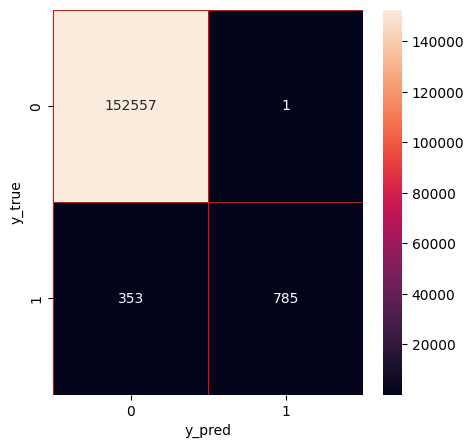

In [60]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [61]:
top_3_models

['rf', 'xg', 'lgbm']

Prediction time per sample:  0.0024075551428150536
Accuracy of STK Traditional: 0.9978268790339371
Precision of STK Traditional: 0.997065642228705
Recall of STK Traditional: 0.8545595877090832
F1-score of STK Traditional: 0.9137243021617274
               precision    recall  f1-score   support

Not Slowloris    0.99783   0.99998   0.99891    152558
    Slowloris    0.99630   0.70914   0.82854      1138

     accuracy                        0.99783    153696
    macro avg    0.99707   0.85456   0.91372    153696
 weighted avg    0.99782   0.99783   0.99765    153696



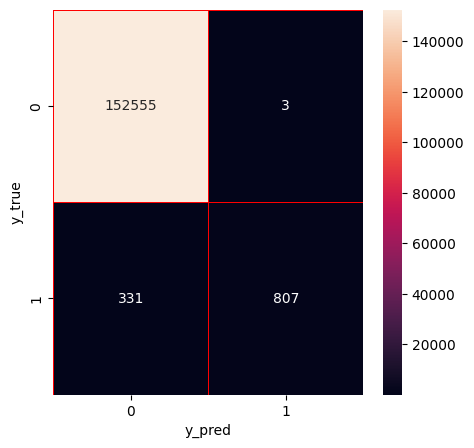

In [62]:
# Ensemble method 1: traditional stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
rf_test = rf.predict(X_test_fs)
xg_test = xg.predict(X_test_fs)
lgbm_test = lgbm.predict(X_test_fs)

rf_test = rf_test.reshape(-1, 1)
xg_test = xg_test.reshape(-1, 1)
lgbm_test = lgbm_test.reshape(-1, 1)

x_test = np.concatenate([rf_test, xg_test, lgbm_test], axis=1)

y_predict = stk1.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Traditional: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Traditional: ' + str(precision))
print('Recall of STK Traditional: ' + str(recall))
print('F1-score of STK Traditional: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0020956654313353733
Accuracy of STK Confidence: 0.9978594107849261
Precision of STK Confidence: 0.9989240419394716
Recall of STK Confidence: 0.8554481546572935
F1-score of STK Confidence: 0.914972484133067
               precision    recall  f1-score   support

Not Slowloris    0.99785   1.00000   0.99892    152558
    Slowloris    1.00000   0.71090   0.83102      1138

     accuracy                        0.99786    153696
    macro avg    0.99892   0.85545   0.91497    153696
 weighted avg    0.99786   0.99786   0.99768    153696



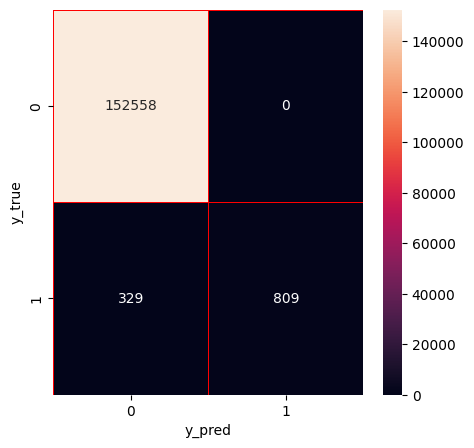

In [63]:
# Ensemble method 2: confidence-based stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
rf_prob_test = rf.predict_proba(X_test_fs)
xg_prob_test = xg.predict_proba(X_test_fs)
lgbm_prob_test = lgbm.predict_proba(X_test_fs)

x_test = np.concatenate([rf_prob_test, xg_prob_test, lgbm_prob_test], axis=1)

y_predict = stk2.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Confidence: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Confidence: ' + str(precision))
print('Recall of STK Confidence: ' + str(recall))
print('F1-score of STK Confidence: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00459421755695204
Accuracy of STK Hybrid: 0.9978268790339371
Precision of STK Hybrid: 0.997065642228705
Recall of STK Hybrid: 0.8545595877090832
F1-score of STK Hybrid: 0.9137243021617274
               precision    recall  f1-score   support

Not Slowloris    0.99783   0.99998   0.99891    152558
    Slowloris    0.99630   0.70914   0.82854      1138

     accuracy                        0.99783    153696
    macro avg    0.99707   0.85456   0.91372    153696
 weighted avg    0.99782   0.99783   0.99765    153696



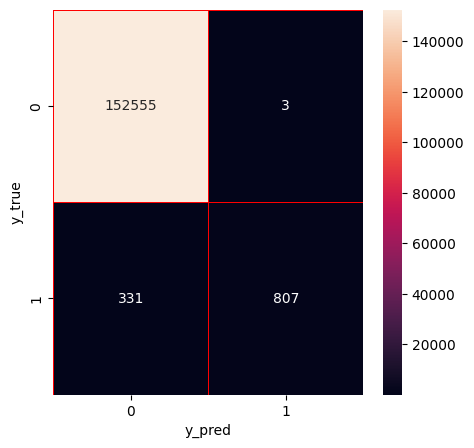

In [64]:
# Ensemble method 3: hybrid stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

rf_test = rf.predict(X_test_fs)
xg_test = xg.predict(X_test_fs)
lgbm_test = lgbm.predict(X_test_fs)

rf_prob_test = rf.predict_proba(X_test_fs)
xg_prob_test = xg.predict_proba(X_test_fs)
lgbm_prob_test = lgbm.predict_proba(X_test_fs)

rf_test = rf_test.reshape(-1, 1)
xg_test = xg_test.reshape(-1, 1)
lgbm_test = lgbm_test.reshape(-1, 1)

x_test = np.concatenate([rf_test, xg_test, lgbm_test] + [rf_prob_test, xg_prob_test, lgbm_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Hybrid: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Hybrid: ' + str(precision))
print('Recall of STK Hybrid: ' + str(recall))
print('F1-score of STK Hybrid: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Port Scan

In [65]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{PS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{PS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/stk3_tuned.pkl")

In [ ]:
fs = ['Bwd RST Flags', 'FWD Init Win Bytes', 'RST Flag Count', 'Flow Duration', 'Packet Length Max', 'Flow Packets/s', 'Protocol', 'Total Length of Fwd Packet', 'Flow IAT Max', 'Fwd Seg Size Min', 'Average Packet Size', 'Packet Length Mean', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Total Fwd Packet', 'Flow Bytes/s', 'Fwd Act Data Pkts', 'Bwd Packets/s', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd Segment Size Avg', 'Fwd Header Length', 'Bwd Packet Length Mean', 'Packet Length Std', 'Fwd IAT Min', 'Packet Length Variance', 'Bwd IAT Max']

In [69]:
top_3_models = ['et', 'rf', 'lgbm']

In [70]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

array([0, 1])

In [87]:
X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

#### KSQL

Accuracy of KSQL: 0.9881389235894232
Precision of KSQL: 0.9887785125172622
Recall of KSQL: 0.9881389235894232
F1-score of KSQL: 0.9882590722966741
              precision    recall  f1-score   support

Not Portscan    0.99998   0.98507   0.99247    121888
    Portscan    0.94587   0.99991   0.97214     31808

    accuracy                        0.98814    153696
   macro avg    0.97292   0.99249   0.98230    153696
weighted avg    0.98878   0.98814   0.98826    153696



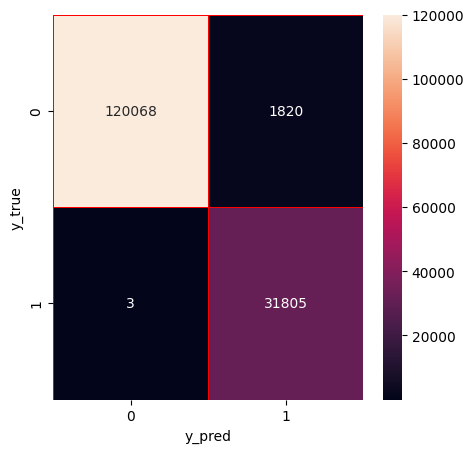

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_pred_ksql_ps, average='weighted')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_ps, y_pred_ksql_ps)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_ps, y_pred_ksql_ps, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_pred_ksql_ps)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [39]:
flink_test_binary_ps[flink_test_binary_ps['Label'] == 'Portscan']['Src IP'].unique()

array(['172.16.0.1'], dtype=object)

In [44]:
len(flink_test_binary_ps[(flink_test_binary_ps['Label'] == 'Benign') & (flink_test_binary_ps['Binary Prediction'] == 'Portscan')]['Src Port'].unique())

1786

In [ ]:
len(flink_test_binary_ps[(flink_test_binary_ps['Label'] == 'Portscan') & (flink_test_binary_ps['Binary Prediction'] == 'Portscan')]['Src Port'].unique())

8105

In [53]:
flink_test_binary_ps[(flink_test_binary_ps['Label'] == 'Portscan') & (flink_test_binary_ps['Binary Prediction'] == 'Portscan')]['Dst Port']

63614     3372
63615     7004
63616     2144
63617     1862
63618     1078
          ... 
115515      21
115516      22
115608      80
115609     445
115617     139
Name: Dst Port, Length: 31805, dtype: int64

In [60]:
predicted_as_ps = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan')]

In [65]:
len((predicted_as_ps["Dst IP"] + predicted_as_ps["Dst Port"].astype(str)).unique())

1071

In [68]:
ksqldb_failed = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Benign')]

In [88]:
ksqldb_failed

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
74612,192.168.10.8,8352,192.168.10.50,61904,6,2017-07-07 17:55:58.667877,23925.0,17,10,20514.0,...,0,4,5,9,23925,Benign,897704,Portscan,both,Not Portscan
74613,192.168.10.8,8351,192.168.10.50,21,6,2017-07-07 17:55:58.539781,152430.0,22,27,176.0,...,0,12,13,25,152430,Benign,989479,Portscan,both,Not Portscan
77015,192.168.10.50,6106,172.16.0.1,53126,6,2017-07-07 17:55:45.864352,1.0,1,1,0.0,...,0,0,0,0,1,Benign,669203,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


#### Machine Learning

Prediction time per sample:  6.531473996116548e-05
Accuracy of DT: 0.9995835935873413
Precision of DT: 0.9997376016793493
Recall of DT: 0.9989939637826961
F1-score of DT: 0.9993652417314904
              precision    recall  f1-score   support

Not Portscan    0.99948   1.00000   0.99974    121888
    Portscan    1.00000   0.99799   0.99899     31808

    accuracy                        0.99958    153696
   macro avg    0.99974   0.99899   0.99937    153696
weighted avg    0.99958   0.99958   0.99958    153696



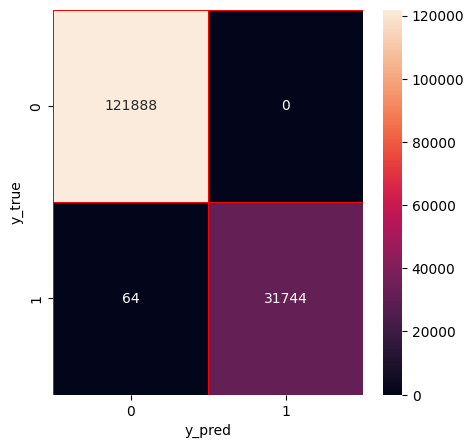

In [112]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0008635879084142129
Accuracy of RF: 0.9995640745367479
Precision of RF: 0.9997253085154361
Recall of RF: 0.99894680583501
F1-score of RF: 0.9993354642434495
              precision    recall  f1-score   support

Not Portscan    0.99945   1.00000   0.99973    121888
    Portscan    1.00000   0.99789   0.99895     31808

    accuracy                        0.99956    153696
   macro avg    0.99973   0.99895   0.99934    153696
weighted avg    0.99956   0.99956   0.99956    153696



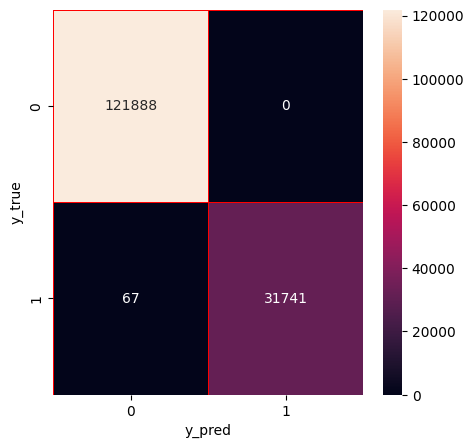

In [113]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.002754797494686968
Accuracy of ET: 0.9995966062877368
Precision of ET: 0.9997457974579746
Recall of ET: 0.9990254024144869
F1-score of ET: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



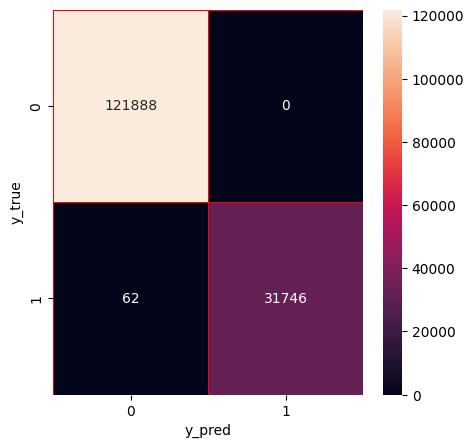

In [114]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0001329935617107365
Accuracy of XG: 0.9995966062877368
Precision of XG: 0.9997457974579746
Recall of XG: 0.9990254024144869
F1-score of XG: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



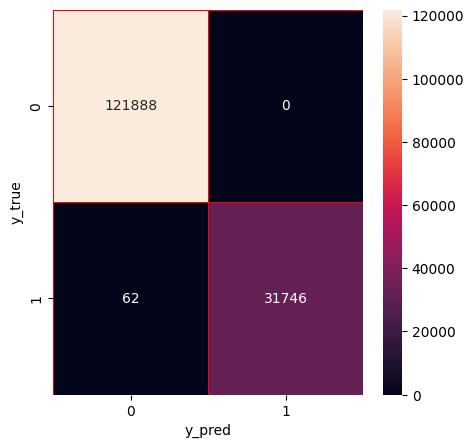

In [115]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0003371639795758043
Accuracy of LGBM: 0.9995966062877368
Precision of LGBM: 0.9997457974579746
Recall of LGBM: 0.9990254024144869
F1-score of LGBM: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



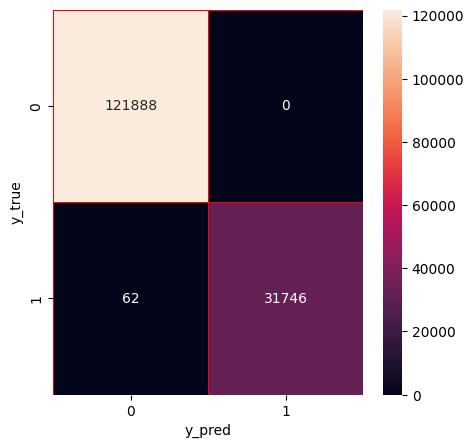

In [116]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00013459753846218754
Accuracy of Cat: 0.9995966062877368
Precision of Cat: 0.9997457974579746
Recall of Cat: 0.9990254024144869
F1-score of Cat: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



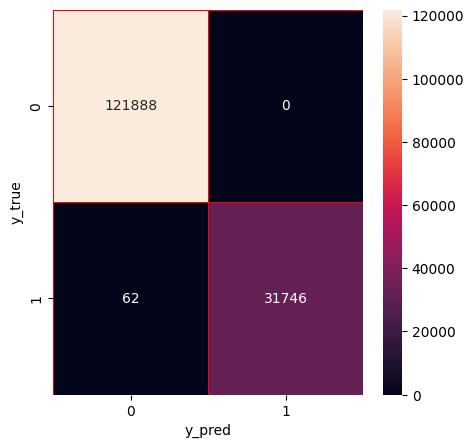

In [117]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [118]:
top_3_models

['et', 'rf', 'lgbm']

Prediction time per sample:  0.004336588486467528
Accuracy of STK Traditional: 0.9995966062877368
Precision of STK Traditional: 0.9997457974579746
Recall of STK Traditional: 0.9990254024144869
F1-score of STK Traditional: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



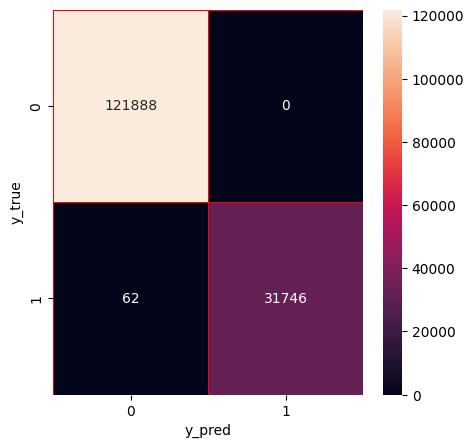

In [120]:
# Ensemble method 1: traditional stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
lgbm_test = lgbm.predict(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
lgbm_test = lgbm_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, lgbm_test], axis=1)

y_predict = stk1.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of STK Traditional: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of STK Traditional: ' + str(precision))
print('Recall of STK Traditional: ' + str(recall))
print('F1-score of STK Traditional: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.004305618084298554
Accuracy of STK Confidence: 0.9995640745367479
Precision of STK Confidence: 0.9997253085154361
Recall of STK Confidence: 0.99894680583501
F1-score of STK Confidence: 0.9993354642434495
              precision    recall  f1-score   support

Not Portscan    0.99945   1.00000   0.99973    121888
    Portscan    1.00000   0.99789   0.99895     31808

    accuracy                        0.99956    153696
   macro avg    0.99973   0.99895   0.99934    153696
weighted avg    0.99956   0.99956   0.99956    153696



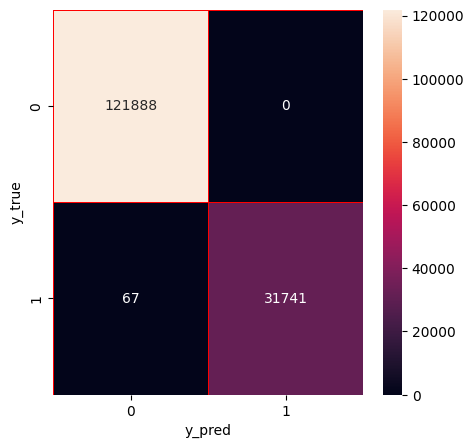

In [121]:
# Ensemble method 2: confidence-based stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
lgbm_prob_test = lgbm.predict_proba(X_test_fs)

x_test = np.concatenate([et_prob_test, rf_prob_test, lgbm_prob_test], axis=1)

y_predict = stk2.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of STK Confidence: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of STK Confidence: ' + str(precision))
print('Recall of STK Confidence: ' + str(recall))
print('F1-score of STK Confidence: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.007910589960349641
Accuracy of STK Hybrid: 0.9995966062877368
Precision of STK Hybrid: 0.9997457974579746
Recall of STK Hybrid: 0.9990254024144869
F1-score of STK Hybrid: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



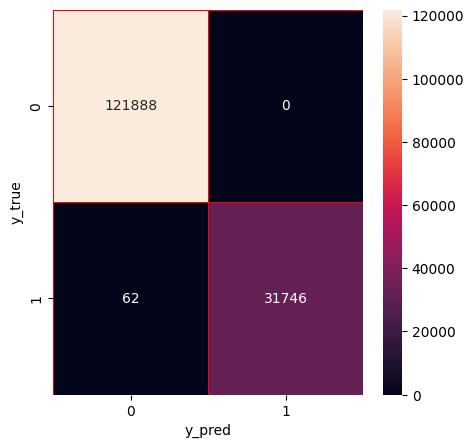

In [123]:
# Ensemble method 3: hybrid stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
lgbm_test = lgbm.predict(X_test_fs)

et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
lgbm_prob_test = lgbm.predict_proba(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
lgbm_test = lgbm_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, lgbm_test] + [et_prob_test, rf_prob_test, lgbm_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of STK Hybrid: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of STK Hybrid: ' + str(precision))
print('Recall of STK Hybrid: ' + str(recall))
print('F1-score of STK Hybrid: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Inference Time

In [46]:
TRIES = 100

In [47]:
# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_test_fs)) * 1000)
    return np.average(times)

In [48]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

## DoS

In [58]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{DOS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{DOS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd IAT Min', 'Bwd IAT Mean', 'Fwd Seg Size Min', 'Flow Packets/s', 'Fwd Packets/s', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Bwd IAT Min', 'Flow IAT Mean', 'FIN Flag Count', 'Bwd Init Win Bytes', 'Fwd Bulk Rate Avg', 'Active Min', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Header Length', 'Bwd Packet Length Mean', 'Subflow Bwd Bytes', 'Flow Duration', 'Flow IAT Min', 'Total Bwd packets', 'Fwd Segment Size Avg', 'FWD Init Win Bytes', 'Packet Length Mean', 'Down/Up Ratio', 'ACK Flag Count', 'Fwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Max', 'Subflow Fwd Packets', 'Fwd Bytes/Bulk Avg', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd Header Length']

top_3_models = ['rf', 'xg', 'lgbm']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [51]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs), TRIES)))

# Ensemble 1 (Change based on training's top 3 models results)
def stk1_timer():
    rf_test = rf.predict(X_test_fs)
    xg_test = xg.predict(X_test_fs)
    lgbm_test = lgbm.predict(X_test_fs)

    rf_test = rf_test.reshape(-1, 1)
    xg_test = xg_test.reshape(-1, 1)
    lgbm_test = lgbm_test.reshape(-1, 1)

    x_test = np.concatenate([rf_test, xg_test, lgbm_test], axis=1)

    stk1.predict(x_test)

dos_inference_times.append(("STK Traditional", calculate_inference_time_in_ms(stk1_timer, TRIES)))

# Ensemble 2 (Change based on training's top 3 models results)
def stk2_timer():
    rf_prob_test = rf.predict_proba(X_test_fs)
    xg_prob_test = xg.predict_proba(X_test_fs)
    lgbm_prob_test = lgbm.predict_proba(X_test_fs)

    x_test = np.concatenate([rf_prob_test, xg_prob_test, lgbm_prob_test], axis=1)

    stk2.predict(x_test)

dos_inference_times.append(("STK Confidence", calculate_inference_time_in_ms(stk2_timer, TRIES)))

# Ensemble 3 (Change based on training's top 3 models results)
def stk3_timer():
    rf_test = rf.predict(X_test_fs)
    xg_test = xg.predict(X_test_fs)
    lgbm_test = lgbm.predict(X_test_fs)

    rf_prob_test = rf.predict_proba(X_test_fs)
    xg_prob_test = xg.predict_proba(X_test_fs)
    lgbm_prob_test = lgbm.predict_proba(X_test_fs)

    rf_test = rf_test.reshape(-1, 1)
    xg_test = xg_test.reshape(-1, 1)
    lgbm_test = lgbm_test.reshape(-1, 1)

    x_test = np.concatenate([rf_test, xg_test, lgbm_test] + [rf_prob_test, xg_prob_test, lgbm_prob_test], axis=1)

    stk3.predict(x_test)

dos_inference_times.append(("STK Hybrid", calculate_inference_time_in_ms(stk3_timer, TRIES)))

In [52]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

[('XG', 0.00010066429339620736),
 ('DT', 0.00010212270227690771),
 ('Cat', 0.00014009792221950142),
 ('LGBM', 0.0004986475035470649),
 ('ET', 0.000827747699421643),
 ('RF', 0.0014065719819828394),
 ('STK Confidence', 0.0021251716540303055),
 ('STK Traditional', 0.0024215067932066166),
 ('STK Hybrid', 0.004266913054934051)]

In [53]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['XG', '0.00010'],
 ['DT', '0.00010'],
 ['Cat', '0.00014'],
 ['LGBM', '0.00050'],
 ['ET', '0.00083'],
 ['RF', '0.00141'],
 ['STK Confidence', '0.00213'],
 ['STK Traditional', '0.00242'],
 ['STK Hybrid', '0.00427']]

In [59]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs), TRIES)))

# Ensemble 1 (Change based on training's top 3 models results)
def stk1_timer():
    rf_test = rf.predict(X_test_fs)
    xg_test = xg.predict(X_test_fs)
    lgbm_test = lgbm.predict(X_test_fs)

    rf_test = rf_test.reshape(-1, 1)
    xg_test = xg_test.reshape(-1, 1)
    lgbm_test = lgbm_test.reshape(-1, 1)

    x_test = np.concatenate([rf_test, xg_test, lgbm_test], axis=1)

    stk1.predict(x_test)

dos_inference_times.append(("STK Traditional", calculate_inference_time_in_ms(stk1_timer, TRIES)))

# Ensemble 2 (Change based on training's top 3 models results)
def stk2_timer():
    rf_prob_test = rf.predict_proba(X_test_fs)
    xg_prob_test = xg.predict_proba(X_test_fs)
    lgbm_prob_test = lgbm.predict_proba(X_test_fs)

    x_test = np.concatenate([rf_prob_test, xg_prob_test, lgbm_prob_test], axis=1)

    stk2.predict(x_test)

dos_inference_times.append(("STK Confidence", calculate_inference_time_in_ms(stk2_timer, TRIES)))

# Ensemble 3 (Change based on training's top 3 models results)
def stk3_timer():
    rf_test = rf.predict(X_test_fs)
    xg_test = xg.predict(X_test_fs)
    lgbm_test = lgbm.predict(X_test_fs)

    rf_prob_test = rf.predict_proba(X_test_fs)
    xg_prob_test = xg.predict_proba(X_test_fs)
    lgbm_prob_test = lgbm.predict_proba(X_test_fs)

    rf_test = rf_test.reshape(-1, 1)
    xg_test = xg_test.reshape(-1, 1)
    lgbm_test = lgbm_test.reshape(-1, 1)

    x_test = np.concatenate([rf_test, xg_test, lgbm_test] + [rf_prob_test, xg_prob_test, lgbm_prob_test], axis=1)

    stk3.predict(x_test)

dos_inference_times.append(("STK Hybrid", calculate_inference_time_in_ms(stk3_timer, TRIES)))

In [60]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

[('XG', 9.746949436414894e-05),
 ('DT', 0.00010107589802989208),
 ('Cat', 0.00014754501253819432),
 ('LGBM', 0.0005238073525666049),
 ('ET', 0.0008764895124780917),
 ('RF', 0.0014659438019317065),
 ('STK Confidence', 0.002098328560162603),
 ('STK Traditional', 0.0023168730141345643),
 ('STK Hybrid', 0.004200042426499282)]

In [61]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['XG', '0.00010'],
 ['DT', '0.00010'],
 ['Cat', '0.00015'],
 ['LGBM', '0.00052'],
 ['ET', '0.00088'],
 ['RF', '0.00147'],
 ['STK Confidence', '0.00210'],
 ['STK Traditional', '0.00232'],
 ['STK Hybrid', '0.00420']]

## Port Scan

In [54]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{PS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{PS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Bwd RST Flags', 'FWD Init Win Bytes', 'RST Flag Count', 'Flow Duration', 'Packet Length Max', 'Flow Packets/s', 'Protocol', 'Total Length of Fwd Packet', 'Flow IAT Max', 'Fwd Seg Size Min', 'Average Packet Size', 'Packet Length Mean', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Total Fwd Packet', 'Flow Bytes/s', 'Fwd Act Data Pkts', 'Bwd Packets/s', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Flow IAT Mean', 'Flow IAT Min', 'Fwd Segment Size Avg', 'Fwd Header Length', 'Bwd Packet Length Mean', 'Packet Length Std', 'Fwd IAT Min', 'Packet Length Variance', 'Bwd IAT Max']

top_3_models = ['et', 'rf', 'lgbm']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

In [55]:
ps_inference_times: list[tuple] = []

# Decision Tree
ps_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))

# Random Forest
ps_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))

# Extra Trees
ps_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))

# XGBoost
ps_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))

# LightGBM
ps_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))

# CatBoost
ps_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs), TRIES)))

# Ensemble 1 (Change based on training's top 3 models results)
def stk1_timer():
    et_test = et.predict(X_test_fs)
    rf_test = rf.predict(X_test_fs)
    lgbm_test = lgbm.predict(X_test_fs)

    et_test = et_test.reshape(-1, 1)
    rf_test = rf_test.reshape(-1, 1)
    lgbm_test = lgbm_test.reshape(-1, 1)

    x_test = np.concatenate([et_test, rf_test, lgbm_test], axis=1)

    stk1.predict(x_test)

ps_inference_times.append(("STK Traditional", calculate_inference_time_in_ms(stk1_timer, TRIES)))

# Ensemble 2 (Change based on training's top 3 models results)
def stk2_timer():
    et_prob_test = et.predict_proba(X_test_fs)
    rf_prob_test = rf.predict_proba(X_test_fs)
    lgbm_prob_test = lgbm.predict_proba(X_test_fs)

    x_test = np.concatenate([et_prob_test, rf_prob_test, lgbm_prob_test], axis=1)

    stk2.predict(x_test)

ps_inference_times.append(("STK Confidence", calculate_inference_time_in_ms(stk2_timer, TRIES)))

# Ensemble 3 (Change based on training's top 3 models results)
def stk3_timer():
    et_test = et.predict(X_test_fs)
    rf_test = rf.predict(X_test_fs)
    lgbm_test = lgbm.predict(X_test_fs)

    et_prob_test = et.predict_proba(X_test_fs)
    rf_prob_test = rf.predict_proba(X_test_fs)
    lgbm_prob_test = lgbm.predict_proba(X_test_fs)

    et_test = et_test.reshape(-1, 1)
    rf_test = rf_test.reshape(-1, 1)
    lgbm_test = lgbm_test.reshape(-1, 1)

    x_test = np.concatenate([et_test, rf_test, lgbm_test] + [et_prob_test, rf_prob_test, lgbm_prob_test], axis=1)

    stk3.predict(x_test)

ps_inference_times.append(("STK Hybrid", calculate_inference_time_in_ms(stk3_timer, TRIES)))

In [56]:
ps_times = sorted(ps_inference_times, key=lambda x: x[1])
ps_times

[('DT', 8.318349083041291e-05),
 ('XG', 8.553131567843625e-05),
 ('Cat', 0.00011594825279407394),
 ('LGBM', 0.0003177353845842923),
 ('RF', 0.0007984804289305729),
 ('ET', 0.0029891115531260194),
 ('STK Confidence', 0.004048482554668241),
 ('STK Traditional', 0.004158564347811796),
 ('STK Hybrid', 0.008194513949359083)]

In [57]:
[[a, format(b, '.5f')] for a, b in ps_times]

[['DT', '0.00008'],
 ['XG', '0.00009'],
 ['Cat', '0.00012'],
 ['LGBM', '0.00032'],
 ['RF', '0.00080'],
 ['ET', '0.00299'],
 ['STK Confidence', '0.00405'],
 ['STK Traditional', '0.00416'],
 ['STK Hybrid', '0.00819']]

# Analysis

In [3]:
flink_train = pd.read_csv('../datasets/output/train_final.csv', index_col=0)
flink_train

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
Flow ID,,,,,,,,,,,,,,,,,,,,,
6b19ab16-1dbb-4f73-ba57-3dfddf145bce,192.168.10.17,49453,192.168.10.3,389,6,2017-07-05 11:42:48.570260,527.0,12,7,172.0,...,0.0,0.0,0,0,6,3,9,527,Benign,807500
61e29423-21b4-4724-ba8b-3f62c917193c,192.168.10.17,46124,192.168.10.3,88,6,2017-07-05 11:42:48.583448,1194.0,11,9,3150.0,...,0.0,0.0,0,0,5,4,9,1194,Benign,582651
95e9bc0a-0c9c-4cae-8732-ba6bcbba31f5,192.168.10.17,49454,192.168.10.3,389,6,2017-07-05 11:42:48.571557,15185.0,16,12,3452.0,...,0.0,0.0,0,0,8,4,12,15185,Benign,1038592
02570213-ef94-4b09-8bd1-dd8310f90311,192.168.10.17,46126,192.168.10.3,88,6,2017-07-05 11:42:48.627714,1186.0,10,9,3150.0,...,0.0,0.0,0,0,6,4,10,1186,Benign,953244
aadcae10-dcf9-4545-a988-f24bf6da8637,192.168.10.17,49460,192.168.10.3,389,6,2017-07-05 11:42:49.114734,483.0,12,7,172.0,...,0.0,0.0,0,0,6,3,9,483,Benign,780889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34e22084-eddc-425d-a027-f2ada71f489b,192.168.10.50,42910,192.168.10.3,389,6,2017-07-07 20:02:38.387716,72263.0,8,4,1612.0,...,0.0,0.0,0,0,4,2,6,126534055,Benign,815720
047c1c20-7c9d-4b0d-b142-512944fb426f,192.168.10.8,10414,192.168.10.3,445,6,2017-07-07 20:02:38.575222,247267.0,16,12,1624.0,...,0.0,0.0,0,0,8,6,14,247267,Benign,688082
5d4f98d3-b002-4720-938e-abcbeba6ec2f,192.168.10.8,51617,192.168.10.3,53,17,2017-07-07 20:02:38.574765,261.0,2,2,64.0,...,0.0,0.0,0,0,0,0,0,261,Benign,877141


In [8]:
X_train_fs = flink_train[fs]
y_train = labelencoder.transform(flink_train['Label'])

Prediction time per sample:  0.0124940391439959
Accuracy of STK Hybrid: 0.9977748571874715
Precision of STK Hybrid: 0.9988816366038378
Recall of STK Hybrid: 0.8497363796133568
F1-score of STK Hybrid: 0.9110224052633935
               precision    recall  f1-score   support

Not Slowloris    0.99776   1.00000   0.99888    152560
    Slowloris    1.00000   0.69947   0.82316      1138

     accuracy                        0.99777    153698
    macro avg    0.99888   0.84974   0.91102    153698
 weighted avg    0.99778   0.99777   0.99758    153698



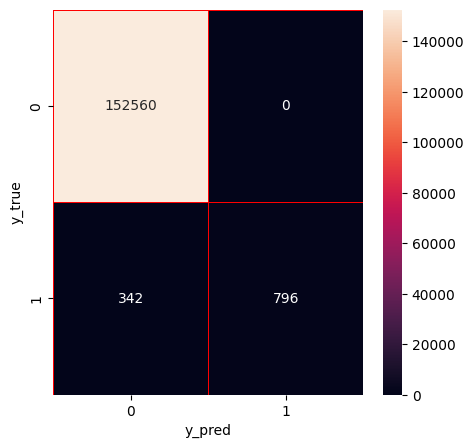

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Ensemble method 3: hybrid stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
cat_test = cat.predict(X_test_fs)

et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
cat_prob_test = cat.predict_proba(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
cat_test = cat_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, cat_test] + [et_prob_test, rf_prob_test, cat_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Hybrid: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Hybrid: ' + str(precision))
print('Recall of STK Hybrid: ' + str(recall))
print('F1-score of STK Hybrid: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [129]:
X_test_fs

,Fwd Seg Size Min,Bwd RST Flags,Flow Duration,Bwd Segment Size Avg,Bwd Act Data Pkts,Protocol,Bwd Packet Length Max,Flow IAT Max,Fwd IAT Min,Bwd Packet Length Mean,...,Fwd Header Length,Bwd Header Length,Fwd Packet Length Min,Bwd Packets/s,Bwd Packet Length Std,Fwd IAT Std,Fwd Bulk Rate Avg,Total Bwd packets,Subflow Fwd Packets,Bwd IAT Max
Flow ID,,,,,,,,,,,,,,,,,,,,,
67fe01c7-f0d3-40ae-9734-11b87bbad3bd,20,0,85742.0,849.666667,4,6,2920.0,25870.0,4.0,849.666667,...,212,132,0.0,69.977374,1149.916461,11978.634714,0.0,6,0.0,36090.0
8ae50662-7e0b-4ead-8e28-239831b9ef68,32,0,1038445.0,329.166667,5,6,1448.0,292001.0,217.0,329.166667,...,328,392,0.0,11.555740,553.194826,119618.922107,0.0,12,0.0,292001.0
25b06579-d96c-48a0-a51d-7a430954b846,20,0,70672.0,171.600000,1,6,858.0,23364.0,109.0,171.600000,...,112,112,0.0,70.749377,383.709265,13589.575573,0.0,5,0.0,23512.0
9e187a13-ffe2-4a44-8a8c-b624bc5b770d,20,0,217279.0,585.000000,7,6,1877.0,50457.0,375.0,585.000000,...,192,224,0.0,50.626153,785.136167,26965.015766,0.0,11,0.0,97524.0
5edd0384-aa65-487b-b9e5-33ebc63cbe0f,20,0,219470.0,563.125000,5,6,1460.0,50485.0,217.0,563.125000,...,172,164,0.0,36.451451,743.163785,28284.313199,0.0,8,0.0,128253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007ea08-91f4-4f7e-88bb-2028c6a83115,8,0,150.0,23.000000,2,17,23.0,145.0,3.0,23.000000,...,16,16,23.0,13333.333333,0.000000,0.000000,0.0,2,0.0,2.0
f94bf22a-875b-4e88-ad42-ffae18afde65,8,0,195.0,23.000000,2,17,23.0,181.0,13.0,23.000000,...,16,16,23.0,10256.410256,0.000000,0.000000,0.0,2,0.0,1.0
f62720f2-cdfe-4fa3-b54e-530f595e0007,8,0,176.0,23.000000,2,17,23.0,126.0,2.0,23.000000,...,16,16,23.0,11363.636364,0.000000,0.000000,0.0,2,0.0,48.0


In [158]:
targeted_mask = (y_true_dos == 'Slowloris') & (pd.Series(y_predict) != 'Slowloris')
failed_idx = targeted_mask[targeted_mask].index
failed_idx

Index([ 1380,  1381,  1382,  1383,  1384,  1385,  1386,  1387,  1388,  1389,
       ...
        1811,  1812,  1817,  1818,  1827,  1829, 42029, 42036, 42037, 42040],
      dtype='int64', length=342)

In [ ]:
targeted_mask = (y_true_ps == 'PortScan')
portscan_idx = targeted_mask[targeted_mask].index
portscan_idx

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X_failures contains instances your model gets wrong
pca = PCA(n_components=2)
pca.fit(X_train_fs)  # X_all is your complete dataset

PCA(n_components=2)

In [194]:
X_train_pca = pca.transform(X_train_fs)
X_test_pca = pca.transform(X_test_fs)

array(['Benign', 'Benign', 'Benign', ..., 'Benign', 'Benign', 'Benign'],
      dtype='<U9')

In [54]:
targeted_mask = pd.Series(labelencoder.inverse_transform(y_train) == 'Slowloris')
train_dos_idx = targeted_mask[targeted_mask].index
train_dos_idx

Index([25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324, 25325,
       ...
       87827, 87828, 87829, 87830, 87831, 87832, 87833, 87834, 87835, 87836],
      dtype='int64', length=4565)

In [55]:
targeted_mask = pd.Series(labelencoder.inverse_transform(y_train) == 'Portscan')
train_ps_idx = targeted_mask[targeted_mask].index
train_ps_idx

Index([410578, 410579, 410581, 410582, 410584, 410588, 410592, 410593, 410596,
       410601,
       ...
       594792, 594793, 594794, 594796, 594799, 594800, 594801, 594802, 594803,
       594804],
      dtype='int64', length=127232)

In [47]:
targeted_mask = (y_true_dos == 'Slowloris') & (pd.Series(y_predict) == 'Slowloris')
test_dos_success_idx = targeted_mask[targeted_mask].index
test_dos_success_idx

Index([  324,   338,   339,   342,   343,   350,   351,   367,   368,   372,
       ...
       41988, 41996, 42005, 42006, 42009, 42011, 42017, 42022, 42023, 42028],
      dtype='int64', length=796)

In [45]:
targeted_mask = (y_true_dos == 'Slowloris') & (pd.Series(y_predict) != 'Slowloris')
test_dos_failed_idx = targeted_mask[targeted_mask].index
test_dos_failed_idx

Index([ 1380,  1381,  1382,  1383,  1384,  1385,  1386,  1387,  1388,  1389,
       ...
        1811,  1812,  1817,  1818,  1827,  1829, 42029, 42036, 42037, 42040],
      dtype='int64', length=342)

In [46]:
targeted_mask = (y_true_dos == 'Slowloris')
test_dos_idx = targeted_mask[targeted_mask].index
test_dos_idx

Index([  324,   338,   339,   342,   343,   350,   351,   367,   368,   372,
       ...
       42009, 42011, 42017, 42022, 42023, 42028, 42029, 42036, 42037, 42040],
      dtype='int64', length=1138)

In [52]:
targeted_mask = (y_true_ps == 'PortScan')
test_ps_idx = targeted_mask[targeted_mask].index
test_ps_idx

Index([ 36196,  36197,  36198,  36200,  36201,  36202,  36203,  36204,  36205,
        36208,
       ...
        96259,  96260,  96265,  96266,  96267,  96268,  96383,  96384,  96395,
       129835],
      dtype='int64', length=31808)

In [220]:
len(X_train_pca[train_dos_idx])

4565

Text(0.5, 1.0, 'PCA Visualization of Failure Cases')

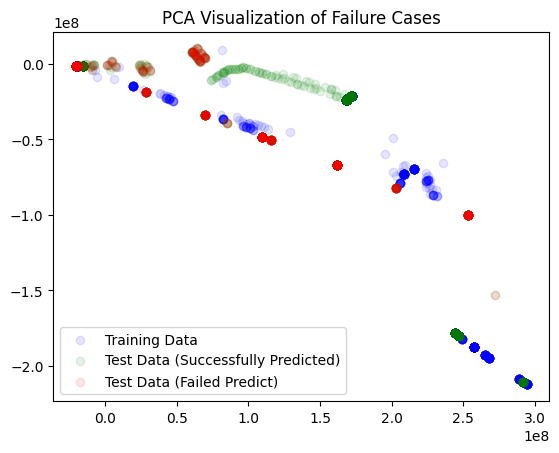

In [221]:
plt.scatter(X_train_pca[train_dos_idx,0], X_train_pca[train_dos_idx,1], c='blue', alpha=0.1, label='Training Data')
plt.scatter(X_test_pca[test_dos_idx,0], X_test_pca[test_dos_idx,1], c='green', alpha=0.1, label='Test Data (Successfully Predicted)')
plt.scatter(X_test_pca[failed_idx,0], X_test_pca[failed_idx,1], c='red', alpha=0.1, label='Test Data (Failed Predict)')
plt.legend()
plt.title('PCA Visualization of Failure Cases')

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, verbose=10)
X_tsne = tsne.fit_transform(X_train_fs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 616981 samples in 0.081s...
[t-SNE] Computed neighbors for 616981 samples in 177.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 616981
[t-SNE] Computed conditional probabilities for sample 2000 / 616981
[t-SNE] Computed conditional probabilities for sample 3000 / 616981
[t-SNE] Computed conditional probabilities for sample 4000 / 616981
[t-SNE] Computed conditional probabilities for sample 5000 / 616981
[t-SNE] Computed conditional probabilities for sample 6000 / 616981
[t-SNE] Computed conditional probabilities for sample 7000 / 616981
[t-SNE] Computed conditional probabilities for sample 8000 / 616981
[t-SNE] Computed conditional probabilities for sample 9000 / 616981
[t-SNE] Computed conditional probabilities for sample 10000 / 616981
[t-SNE] Computed conditional probabilities for sample 11000 / 616981
[t-SNE] Computed conditional probabilities for sample 12000 / 616981
[t-SNE] Computed conditional proba

In [11]:
import joblib
joblib.dump(tsne, "./tsne.pkl")

['./tsne.pkl']

In [ ]:
X_test_tsne = tsne.

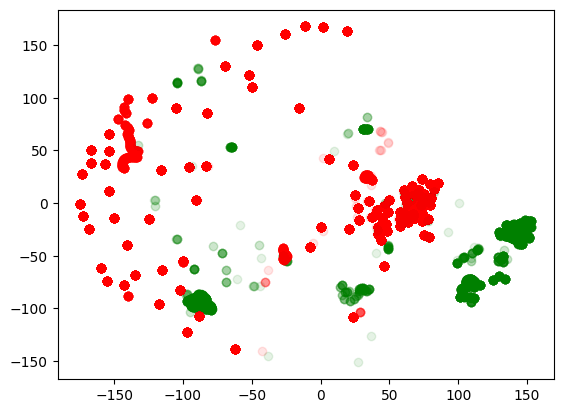

In [71]:
# # plt.scatter(X_tsne[:,0], X_tsne[:,1], c='blue', alpha=0.1)
plt.scatter(X_tsne[train_dos_idx,0], X_tsne[train_dos_idx,1], alpha=0.1, c='green')
plt.scatter(X_tsne[train_ps_idx,0], X_tsne[train_ps_idx,1], alpha=0.1, c='red')
# # plt.scatter(X_tsne[failed_idx,0], X_tsne[failed_idx,1], c='red')

Index([ 36196,  36197,  36198,  36200,  36201,  36202,  36203,  36204,  36205,
        36208,
       ...
        96259,  96260,  96265,  96266,  96267,  96268,  96383,  96384,  96395,
       129835],
      dtype='int64', length=31808)

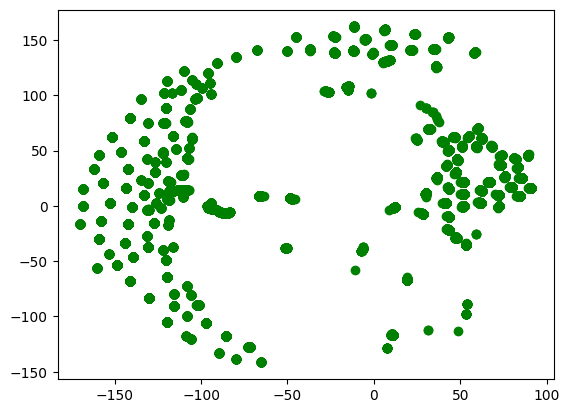

In [172]:
plt.scatter(X_tsne[portscan_idx,0], X_tsne[portscan_idx,1], c='green')